# Youtube US videos data analysis

This notebook aims to perform some data analysis based on the US videos dataset of Youtube.

This dataset is publically avaliable in Kaggle.

In [1]:
import itertools

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import calendar

In [2]:
us_videos = pd.read_csv('data/USvideos.csv')

In [3]:
us_videos.head(n=2)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."


In [4]:
us_videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

Doing some cleaning on data:

In [5]:
us_videos['tags'] = us_videos['tags'].apply(lambda x: x.replace('|',' ').replace('"',""))

In [6]:
# drop videos with same video_id, since it's a duplicate
us_videos.drop_duplicates(subset='video_id', inplace=True)

In [7]:
# average number of viwes, likes, dislikes and comments
us_videos[['views', 'likes', 'dislikes','comment_count']].agg('mean')

views            758209.564478
likes             34493.569832
dislikes           1427.222012
comment_count      4501.707290
dtype: float64

## Analyzing Categories

We chose to begin to analyse the dataset by the category of the video with the hypothesis that different categories
attract different viewers.

This implies that the best time to publish a video or the best words to use on the title of a video may radically differ depending on its category, whiwh is reasonable.
We do not have access to the users that have seen a video here, but if we did, we could do some sort of overlap measure, to check how many viewers in common videos from two categories have.

In [8]:
# Inserting categories names 
category_name = {1:'Film and Animation', 2:'Cars and Vehicles', 10: 'Music', 15:'Pets and Animals', 17:'Sport', 
19:'Travel and Events', 20:'Gaming', 22:'People and Blogs', 23:'Comedy', 24:'Entertainment', 25:'News and Politics',
26:'How to and Style', 27:'Education', 28:'Science and Technology', 29:'Non-profits and activism'}
us_videos['category_name'] = us_videos['category_id'].map(category_name)

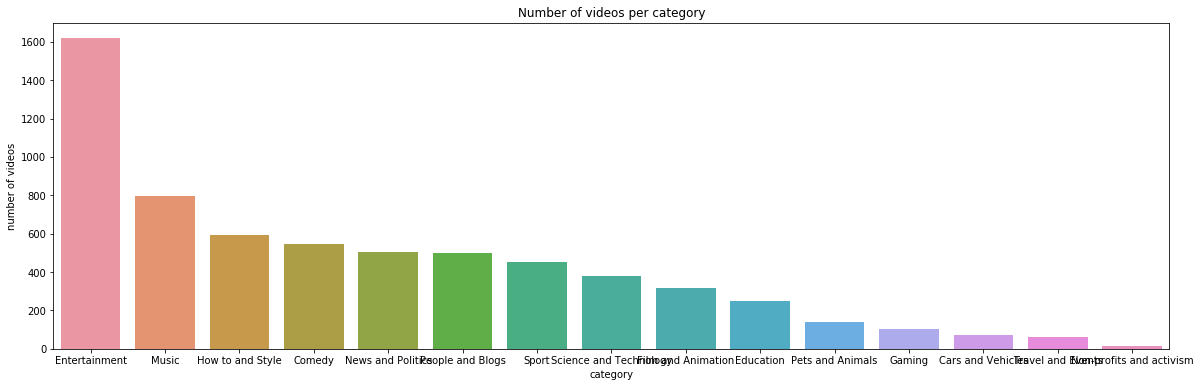

In [9]:
nb_videos_per_category = us_videos['category_name'].value_counts()
plt.figure(figsize=(20,6))
sns.barplot(nb_videos_per_category.index, nb_videos_per_category.values)
plt.title('Number of videos per category')
plt.xlabel('category')
plt.ylabel('number of videos')
plt.show()

We can take a look at the number of likes, dislikes and comments each categories have:

In [10]:
us_videos.groupby('category_name')['likes'].sum()

category_name
Cars and Vehicles             449117
Comedy                      21425434
Education                    3853548
Entertainment               44247100
Film and Animation           9784712
Gaming                       5125603
How to and Style            14210038
Music                       82644713
News and Politics            1950958
Non-profits and activism     1554039
People and Blogs            16043681
Pets and Animals             1564320
Science and Technology       6865912
Sport                        8966861
Travel and Events             335481
Name: likes, dtype: int64

Of course the number of those features in themselves is not interesting, because it could easily be that categories with more
videos have more likes, for example. it's more interesting to look at the number average number of likes each video in a category
has.

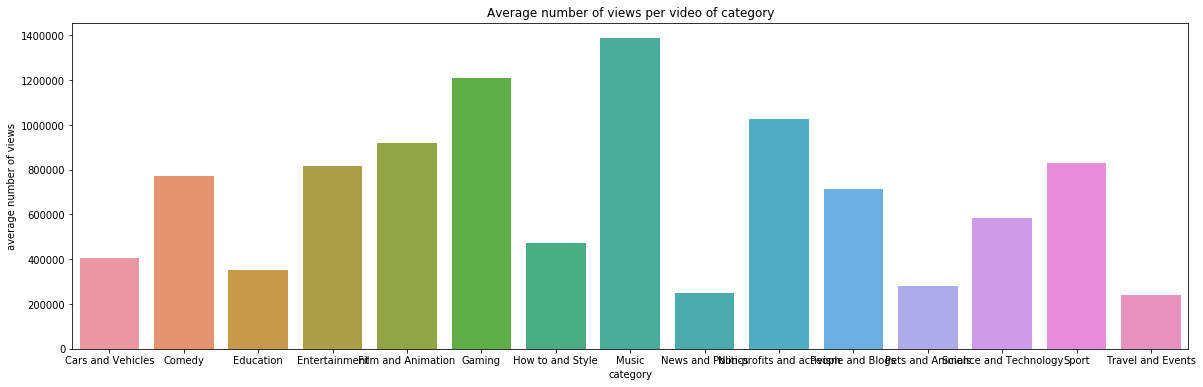

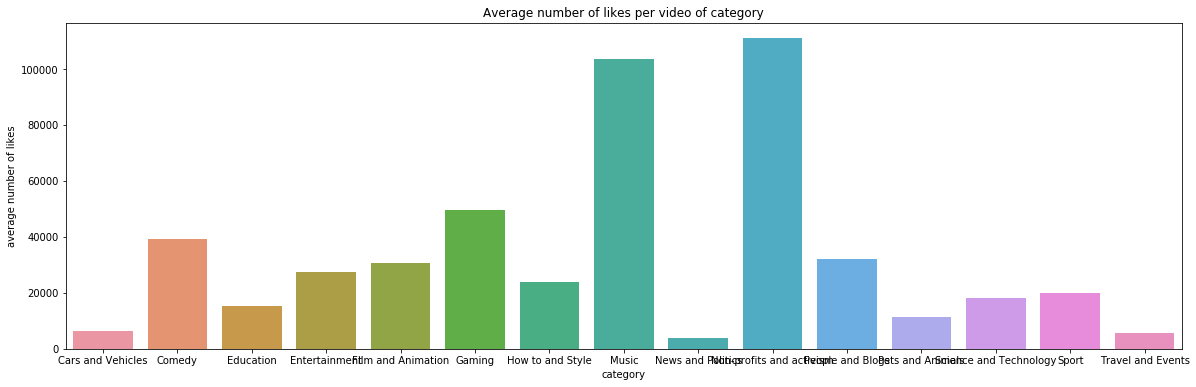

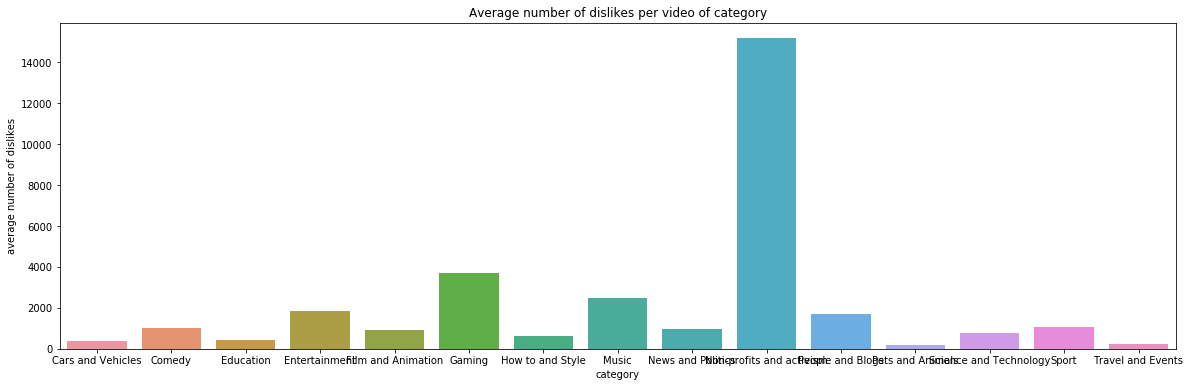

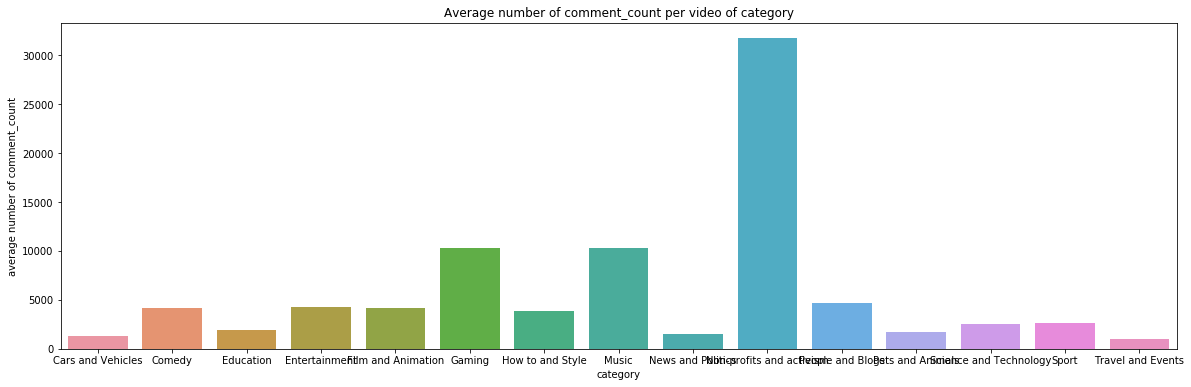

In [11]:
features = ['views','likes', 'dislikes', 'comment_count']
for feat in features:
    avg_nb_per_category = us_videos.groupby('category_name')[feat].sum().divide(nb_videos_per_category)
    plt.figure(figsize=(20,6))
    sns.barplot(avg_nb_per_category.index, avg_nb_per_category.values)
    plt.title(f'Average number of {feat} per video of category')
    plt.xlabel('category')
    plt.ylabel(f'average number of {feat}')
    plt.show()

We can see some interesting things analyzing these. For example, activism videos get a lot of reactivity, both good and bad, even tough they're not very watched.
This is expected because those topics bring up a lot of discussion, especially on the internet. Comparing to music, for example,
the second category with most likes per video, the average number of dislikes is drastically lower.

#### Like and Dislike Scores

From the number of views, likes and dislikes we can give each video a score, that in this case, can represent the probability that a video will receive a like, a dislike or a comment when seen:

In [12]:
us_videos['like_rate'] =  us_videos['likes'] / us_videos['views']
us_videos['dislike_rate'] =  us_videos['dislikes'] / us_videos['views']
us_videos['comment_rate'] =  us_videos['comment_count'] / us_videos['views']

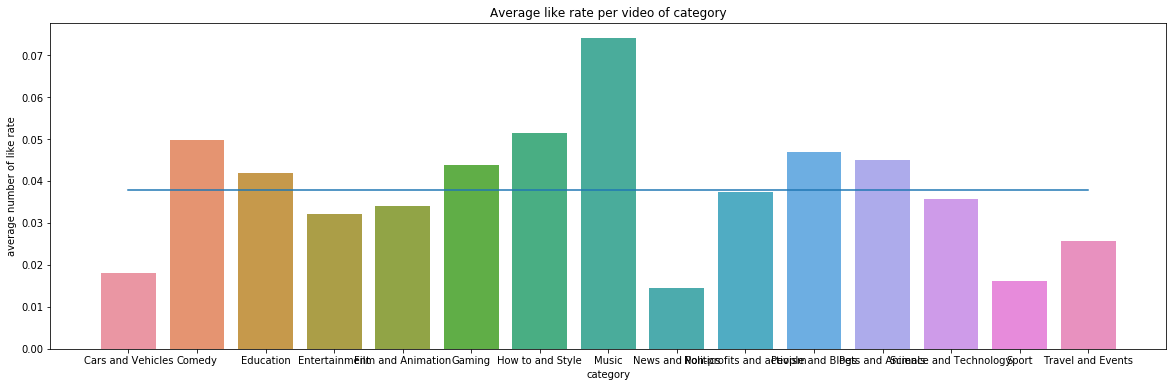

Average general like rate: 0.037746446935707195


In [13]:
avg_like_rate_per_category = us_videos.groupby('category_name')['like_rate'].mean()
plt.figure(figsize=(20,6))
sns.barplot(avg_like_rate_per_category.index, avg_like_rate_per_category.values)
sns.lineplot(avg_like_rate_per_category.index,np.ones(15)*avg_like_rate_per_category.mean())
plt.title('Average like rate per video of category')
plt.xlabel('category')
plt.ylabel('average number of like rate')
plt.show()
print('Average general like rate:', avg_like_rate_per_category.mean())

As it's possible to see, the average like rate is very low. Therefore it's safe to assume that most youtube viewers
present a sort of **passive behavior**, in the sense that they will watch a video but not react to it (give a like, dislike or comment).

## Optimization for views

### Best composition of title and tags

As the Youtube algorithm uses mainly number of views and time watched (how many time a user passed seeing a video),
we could consider the **number of views** as a **target feature**, since in this dataset we don't have access to the second variable.

An useful thing to show to users can be what are the most interesting features to use (in the sense of enchancing views), depending on their category of video production.

Given a category, we can check the most intersting words to use on the title as well as the most interesting tags.

An interesting word will be the one that is present in one or more then one of the 100 most liked videos of a category.

In [14]:
def interesting_words(category=None, use_in='title', top=10):
    """
    Given a category, we'll check the most n interesting words to use in title/tags.
    params:
    category: category name. If None, takes all categories into account.
    use_in: title or tags.
    top: the number of best words to be selected.
    return:
    top n words to used in title/tags.
    """
    us_videos_cp = us_videos.copy()
    if category:
        us_videos_cp = us_videos_cp[us_videos_cp['category_name']==category]
    us_videos_cp[use_in] = us_videos_cp[use_in].apply(lambda x: x.lower().split(' '))
    us_videos_cp.sort_values(by='views', ascending=False, inplace=True)
    us_videos_cp = us_videos_cp.head(n=100).reset_index(drop=True)
    res = list(itertools.chain.from_iterable(us_videos_cp[use_in].values))
    res = [''.join(x for x in i if x.isalpha()) for i in res if i not in ['|', '-']] # filtering words
    res = pd.Series([i for i in res if i !=''], name=f'Most interesting words to put in {use_in}').value_counts().head(top)
    res = pd.DataFrame(res)
    display(res)
    

In [15]:
interesting_words(use_in='tags', top=10)

,Most interesting words to put in tags
dude,73
perfect,63
video,56
bottle,41
flip,41
the,38
official,37
music,35
maluma,34
new,30


In [16]:
interesting_words(use_in='tags', category='Music')

,Most interesting words to put in tags
video,93
the,54
music,54
official,43
eminem,42
maluma,36
mv,31
트와이스,30
new,30
twice,29


The same thing could be done of course using other variables such as the like and dislike rate, etc.

Keeping in mind that when using a variable such as dislikes, the objective should be to look at videos minimizing
that variable.

### Temporal Aspects

Now that we have taken a look in the composition (best words to put in title and tags) using views as target, we could
ask ourselves about the best time to publish a video of a certain category.

In [17]:
us_videos['publish_time'] = pd.to_datetime(us_videos['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')

In [18]:
us_videos['month'] = us_videos['publish_time'].dt.month
us_videos['day'] = us_videos['publish_time'].dt.day
us_videos['year'] = us_videos['publish_time'].dt.year
us_videos['hour'] = us_videos['publish_time'].dt.hour
us_videos['minute'] = us_videos['publish_time'].dt.minute

At first, let's take a look at the 100 most viewed videos month of publication.

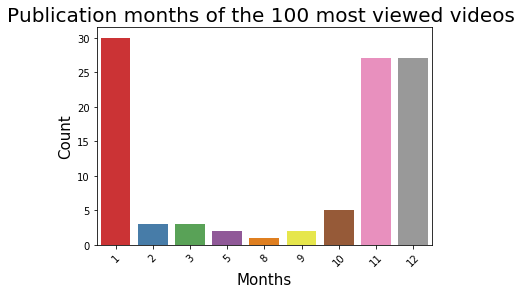

In [19]:
g = sns.countplot('month', data=us_videos.sort_values(by='views').head(100), palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Publication months of the 100 most viewed videos ", fontsize=20)
g.set_xlabel("Months", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.show()

This shows us that the beginning and end of the year are the best times to publish a video.

This could be due to the fact that this is usually a period of vacation (Christimas and New Year), and also is
winter in the US, therefore even tough people have some days off, they don't go out as much as in the summer, leaving
time to watch more videos. This is also confirmed by the general behavior of the distribution, where lower values appear in the spring and summer periods, generally when the weather is good for travelling and doing outside activites.

Of course this could also vary a lot depending on the category of the video.

Let's do the same for the hour of publication.

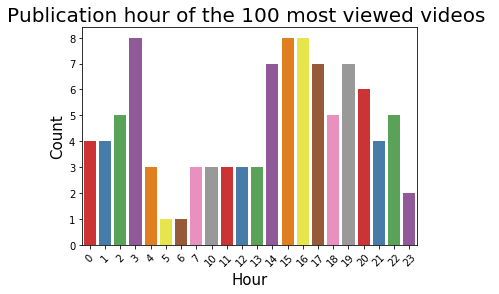

In [20]:
g = sns.countplot('hour', data=us_videos.sort_values(by='views').head(100), palette="Set1")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Publication hour of the 100 most viewed videos ", fontsize=20)
g.set_xlabel("Hour", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.show()

An explanation for this can be that when a video is publish one or two hours before the end of a work day,
people will probably watch it right when they get home. When it's published at night time, people could have already other plans or videos to watch, and in the case of the morning, it could be that people are at work at the time and will just forget to watch the video when they get home, something more difficult to do when the notification it's still fresh in the memory.

In [21]:
def best_time(category=None):
    """
    Given a category, we'll check the most interesting time to publish a video.
    params:
    category: category name. If None, takes all categories into account.
    return:
    best time to publish a video.
    """
    us_videos_cp = us_videos.copy()
    if category:
        us_videos_cp = us_videos_cp[us_videos_cp['category_name']==category]
    us_videos_cp.sort_values(by='views', inplace=True)
    us_videos_cp = us_videos_cp.head(n=100).reset_index(drop=True)
    if category:
        message_month = f'best month to publish a video of category {category} is:'
        message_hour = f'best hour to publish a video of category {category} is:'

    else:
        message_month = f'best month to publish a video is:'
        message_hour = f'best hour to publish a video is:'

    g = sns.countplot('month', data=us_videos_cp, palette="Set1")
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g.set_title("Publication months of the 100 most viewed videos ", fontsize=20)
    g.set_xlabel("Months", fontsize=15)
    g.set_ylabel("Count", fontsize=15)
    plt.show()
    g = sns.countplot('hour', data=us_videos_cp, palette="Set1")
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g.set_title("Publication hour of the 100 most viewed videos ", fontsize=20)
    g.set_xlabel("Hours", fontsize=15)
    g.set_ylabel("Count", fontsize=15)
    plt.show()
    print(message_month, calendar.month_abbr[us_videos_cp['month'].value_counts().index[0]])
    print(message_hour, us_videos_cp['hour'].value_counts().index[0],'h')


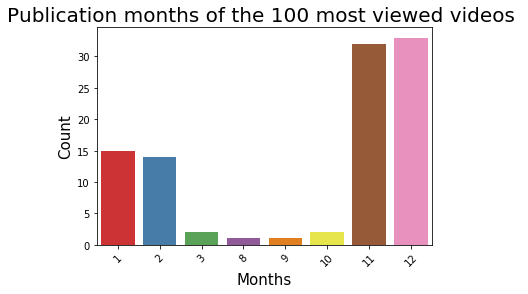

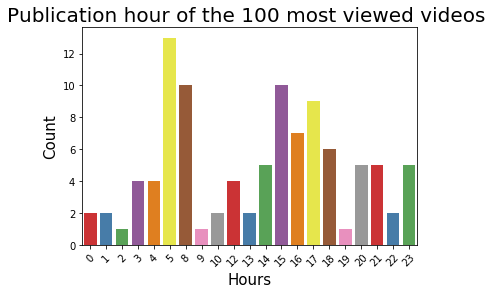

best month to publish a video of category Music is: Dec
best hour to publish a video of category Music is: 5 h


In [22]:
best_time(category='Music')